In [1]:
%load_ext autoreload

In [2]:
import sys
import os
import time
import torch
import pickle
import parkinson

import numpy as np
import pandas as pd
import networkx as nx

from torch import nn
from joblib import Parallel, delayed
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

os.chdir('..')
!export PYTHONPATH=$(pwd):$PYTHONPATH
import parkinson

In [3]:
print(os.listdir('../'))
sys.path.append('../')

['.git', 'Makefile', 'report', 'pyproject.toml', 'parkinson', 'notebooks', 'weights', 'requirements.txt', '.gitignore', 'Parkinson_Diagnosis_Deeplearning.egg-info', 'outputs', 'data', 'README.md']


In [5]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001

# Processamento dos dados

In [6]:
# lendo os arquivos de dados
parkinson_data = parkinson.utils.data.batch_read('data/PDs_columns')
control_data = parkinson.utils.data.batch_read('data/Controls_columns') 

# selecionando as colunas de atlas AAL3, o atlas de conectividade cerebral
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

100%|██████████| 66/66 [00:04<00:00, 13.43it/s]


total de pacientes: 219

In [ ]:
parkinson_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(parkinson_atlas_data)
control_correlation_matrix = parkinson.utils.correlation.sliding_window_correlation(control_atlas_data)

In [10]:
X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])
X, y = parkinson.utils.data.filter_data(X, y)

X, y = parkinson.utils.data.filter_data(X, y)

### Split  
- 60% treino
- 20% validação
- 20% teste

In [11]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

# Aplicando oversampling no conjunto de treino
ros = RandomOverSampler(random_state=RDN)
X_train, y_train = ros.fit_resample(X_train, y_train)

/home/vitor/miniforge3/envs/parkinson/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vitor/miniforge3/envs/parkinson/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/vitor/miniforge3/envs/parkinson/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


### Dataloaders

In [12]:
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

# Treinamento

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.SimpleMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

train-loss: 0.1156  train-acc: 0.9945 | val-loss: 0.4543  val-acc: 0.7955:  34%|███▍      | 68/200 [00:15<00:30,  4.28it/s]

Early stopping at epoch 69


In [14]:
model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

out = parkinson.utils.train.train(model, train_loader, val_loader, device, N_EPOCHS, PATIENCE, LR, "weights/1_correlation_matrix", class_weights=class_weights)

metrics = parkinson.utils.train.evaluate(model, test_loader, device, "weights/1_correlation_matrix",)

In [19]:
%%time
out = parkinson.utils.train.train(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    class_weights=class_weights, 
    device=device, 
    num_epochs=N_EPOCHS, 
    patience=PATIENCE,
    lr=LR
)

train-loss: 0.1123  train-acc: 1.0000 | val-loss: 0.5687  val-acc: 0.7500:  20%|██        | 41/200 [00:13<00:53,  2.97it/s]

Early stopping at epoch 42
CPU times: user 4.67 s, sys: 6.69 s, total: 11.4 s
Wall time: 13.8 s


In [20]:
metrics = parkinson.utils.train.evaluate(model, test_loader, device)
print('Metrics:', metrics)
print('Done.')

Metrics: {'preds': [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1], 'acc': 0.75, 'f1': 0.7166285278413425, 'precision': 0.7346491228070176, 'recall': 0.75}
Done.


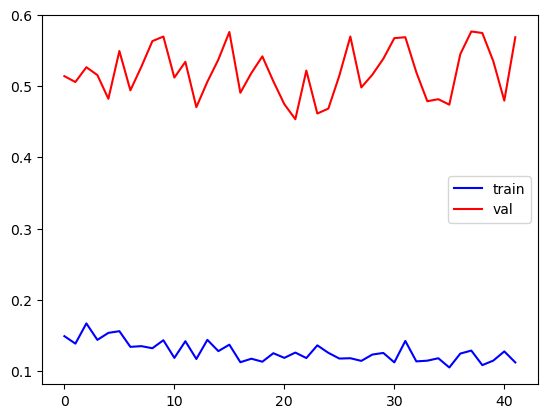

In [21]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/loss_curve_{CORR_METHOD}.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix_{CORR_METHOD}.png", bbox_inches='tight')